In [15]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [16]:
import os
home_path="/media/DATA_18_TB_1/awaghili/WESTPA_CG/harmonic_mix_trpcage_2d/westpa_prop"
os.chdir(home_path)


In [17]:
all_pcoords = []

# skip_iters_until = 30
skip_iters_until = 0
max_iname = 10

file_path = "west.h5"
with h5py.File(file_path, 'r') as h5_file:
    for iname, ival in h5_file["iterations"].items():
        iteration_index = int(iname.split("_")[-1])
        if iteration_index < skip_iters_until:
            print(iname)
            continue
        if iteration_index > max_iname:
            print(iname)
            continue
        iteration_pcoords = ival["pcoord"][:]
        # We only want to include completed segments
        finished_mask = ival["seg_index"]["status"] == 2
        all_pcoords.extend(iteration_pcoords[finished_mask])

all_pcoords = [i.flatten() for i in all_pcoords]

BlockingIOError: [Errno 11] Unable to synchronously open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_path = "west.h5"
num_bins = 80

with h5py.File(file_path, 'r') as h5_file:
    for max_iname in range(1, 62):  # Loop over max_iname from 1 to 61
        all_pcoords = []
        
        for iname, ival in h5_file["iterations"].items():
            iteration_index = int(iname.split("_")[-1])
            if iteration_index < 0 or iteration_index > max_iname:
                continue
            iteration_pcoords = ival["pcoord"][:]
            finished_mask = ival["seg_index"]["status"][:] == 2
            all_pcoords.extend(iteration_pcoords[finished_mask])

        all_pcoords = [i.flatten() for i in all_pcoords]
        component_values = [i for i in all_pcoords]
        
        component_bins = np.linspace(component_min, component_max, num_bins + 1)

        # Bin the data
        binned_components = [
            np.clip((num_bins * (i - component_min) / (component_max - component_min)).astype(int), None, num_bins - 1)
            for i in component_values
        ]

        # Build the transition matrix
        transition_matrix = np.zeros((num_bins, num_bins), dtype=int)
        for i in binned_components:
            for j in range(len(i) - 1):
                transition_matrix[i[j], i[j + 1]] += 1

        # Normalize to get transition probabilities
        transition_prob_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
        transition_prob_matrix = np.nan_to_num(transition_prob_matrix)

        # Solve for the stationary distribution
        eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
        stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]

        if stationary_vector.shape[1] != 1:
            print(f"Warning: Stationary distribution not unique at max_iname={max_iname}")
            continue

        stationary_distribution = stationary_vector[:, 0].real
        stationary_distribution /= stationary_distribution.sum()

        # Plot transition matrix and stationary distribution
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        im0 = axes[0].imshow(transition_prob_matrix.T, origin='lower', aspect='auto', cmap='viridis')
        plt.colorbar(im0, ax=axes[0])
        axes[0].set_xlabel("State i (src)")
        axes[0].set_ylabel("State j (dst)")

        im1 = axes[1].imshow(transition_prob_matrix.T, origin='lower', aspect='auto', cmap='viridis', norm="log")
        plt.colorbar(im1, ax=axes[1])
        axes[1].set_xlabel("State i (src)")
        axes[1].set_ylabel("State j (dst)")
        fig.suptitle(f"State Transition Matrix at max_iname={max_iname}")
        plt.tight_layout()
        plt.show()

        # Plot MSM histogram comparison
        plt.figure()
        plt.title(f"Component Distribution at max_iname={max_iname}")
        all_binned = np.concatenate(binned_components)
        plt.hist(all_binned, bins=num_bins, density=True, alpha=0.5, label="WESTPA observations")
        plt.plot(stationary_distribution, label="MSM equilibrium density")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [ ]:
# component_values = [[i[0], i[-1]] for i in all_pcoords]
component_values = [i for i in all_pcoords]

num_bins = 80
component_min = min([min(i) for i in component_values])
component_max = max([max(i) for i in component_values])
component_bins = np.linspace(component_min, component_max, num_bins+1)
# Calculate the binds ourselves because I can't figure out np.digitize tonight - Daniel
# The np.clip call is needed because math here treats the bins as open ranges on the right [a,b), so the max value gets put in next bin
binned_componenents = [np.clip((num_bins*(i-component_min)/(component_max-component_min)).astype(int), None, num_bins-1) for i in component_values]

for i,j in zip(binned_componenents, component_values):
     bad = i[i >= num_bins]
     if len(bad):
          print(bad)
          print(j > component_max)

transition_matrix = np.zeros((num_bins, num_bins), dtype=int)
for i in binned_componenents:
    for j in range(len(i) - 1):
        try:
            #transition_matrix[from_state][to_state]
            transition_matrix[i[j]][i[j+1]] += 1
        except:
            print(j, j+1)
            raise

In [4]:
transition_matrix

NameError: name 'transition_matrix' is not defined

In [5]:
transition_prob_matrix = transition_matrix.astype(np.double)/np.sum(transition_matrix, axis=1, keepdims=True)
transition_prob_matrix = np.nan_to_num(transition_prob_matrix, nan=0.0)

NameError: name 'transition_matrix' is not defined

NameError: name 'transition_prob_matrix' is not defined

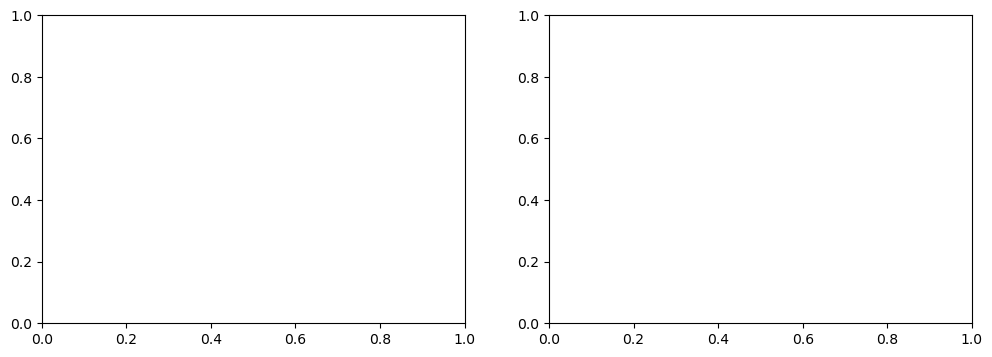

In [6]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
im0 = axes[0].imshow(transition_prob_matrix.T, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(im0, label='Transition Probability', ax=axes[0])
axes[0].set_xlabel('State i (src)')
axes[0].set_ylabel('State j (dst)')
# axes[0].set_title('Transition Matrix')

im1 = axes[1].imshow(transition_prob_matrix.T, origin='lower', aspect='auto', cmap='viridis', norm="log")
plt.colorbar(im1, label='Transition Log Probability', ax=axes[1])
axes[1].set_xlabel('State i (src)')
axes[1].set_ylabel('State j (dst)')
axes[1].set_title('')

fig.suptitle("State Transition Matrix")
pass

In [7]:
# Linear algebra by ChatGPT
# Solve for the stationary distribution
eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]

assert stationary_vector.shape[1] == 1, "Stationary distribution is not unique"

# Normalize the stationary vector to sum to 1
stationary_distribution = stationary_vector / np.sum(stationary_vector)
stationary_distribution = stationary_distribution.real.flatten()

plt.title(f"TICA Componenent")
plt.hist(np.concatenate(binned_componenents), bins=num_bins, density=True, label="WESTPA observations")
plt.plot(stationary_distribution, label="MSM equilibrium density")
plt.legend()
pass

NameError: name 'transition_prob_matrix' is not defined

In [7]:
for i in range(len(transition_prob_matrix)):
    plt.plot(transition_prob_matrix[i].T, label=i, c=plt.colormaps["rainbow"](i/len(transition_prob_matrix)))
plt.ylabel("Probability")
plt.xlabel("Next state")
# plt.legend(title="Current State")

plt.colorbar(
    matplotlib.cm.ScalarMappable(cmap=plt.colormaps["rainbow"]),
    ax=plt.gca(), values=[*range(len(transition_prob_matrix)+1)],
    label="Source State")

# plt.colorbar(
#     matplotlib.cm.ScalarMappable(
#         norm = matplotlib.colors.BoundaryNorm([*range(len(transition_prob_matrix)+1)], plt.colormaps["rainbow"].N),
#         cmap=plt.colormaps["rainbow"]),
#     ax=plt.gca(), label="Source State")

pass

NameError: name 'transition_prob_matrix' is not defined

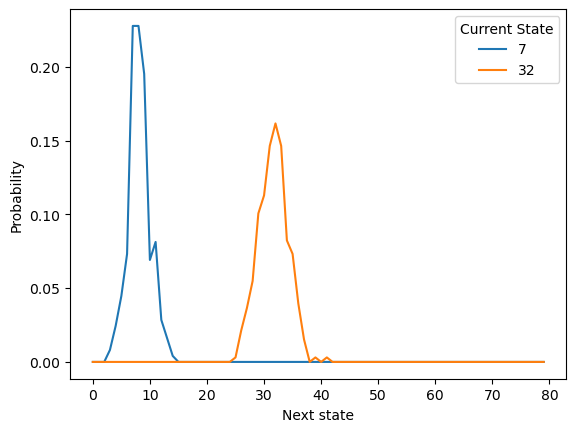

In [11]:
# Examining some individual bins

# for i in range(30,35):
for i in [7, 32]:
    plt.plot(transition_prob_matrix[i].T, label=i)
plt.ylabel("Probability")
plt.xlabel("Next state")
plt.legend(title="Current State")